In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()


In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
gpu_usage()



In [2]:
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/CS893 Sp2022 A2 Dataset/train_and_val_set.tar')
my_tar.extractall('./traindata') # specify which folder to extract to
my_tar.close()
my_tar = tarfile.open('/content/drive/MyDrive/CS893 Sp2022 A2 Dataset/test_set.tar')
my_tar.extractall('./testdata') # specify which folder to extract to
my_tar.close()



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import random
import glob
from torchvision import datasets, transforms, models
import cv2
from torchvision.transforms.functional import center_crop
from torchvision.transforms.transforms import RandomVerticalFlip
from PIL import Image
from torch.utils.data import Dataset
from functools import lru_cache
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from torch.utils.data import  WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score,roc_curve,roc_auc_score,auc,precision_recall_curve
from sklearn.metrics import f1_score



In [3]:
#DataSetPipeLine
img_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),

    'valid':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        #transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),
     }
class ImageDataSet(Dataset):
    def __init__(self, image_paths,path, transform=False):
        self.image_paths = image_paths
        self.path=path
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    @lru_cache()
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        t=image_filepath.split('/')[-1]
        t=t.split('.')[0]
        label1=np.load(self.path+t+'_exp.npy')
        label1=label1.astype(np.float32)
        label1=torch.from_numpy(label1)
        label1 = label1.type(torch.LongTensor)

        label2=np.load(self.path+t+'_aro.npy') #arousal
        label2=label2.astype(np.float32)
        label2=torch.from_numpy(label2)
        label2 = label2.type(torch.FloatTensor)

        label3=np.load(self.path+t+'_val.npy') #Ind
        label3=label3.astype(np.float32)
        label3=torch.from_numpy(label3)
        label2 = label2.type(torch.FloatTensor)




        if self.transform is not None:
            rgbimg = self.transform(rgbimg)
        sample = {'image':rgbimg, 'labels': {'exp':label1, 'arousal':label2, 'val':label3}}
   
        return sample


In [4]:
class MultilabelClassifier(nn.Module):
    def __init__(self, exp, arousal, val):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
                       param.requires_grad = False

        """
        cntr=0
        lt=5
        for child in self.resnet.children():
            cntr+=1

            if cntr < lt:
                for param in child.parameters():
                       param.requires_grad = False
        """
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))
        

        self.exp = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=exp)
        )
        self.arousal = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=arousal)
        )
        self.val = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=val)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'exp': self.exp(x),
            'arousal': self.arousal(x),
            'val': self.val(x)
        }

In [5]:
#LossFunction
def criterion(loss,loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
   if(key=='exp'):
      losses += loss_func(outputs[key],pictures[0])#.cuda()) 
   if(key=='arousal'):
      t= pictures[1].view(len(pictures[1]),1)
      losses += loss(outputs[key],t)
   if(key=='val'):
      t= pictures[2].view(len(pictures[2]),1)
      losses += loss(outputs[key],t) 
      

  return losses
#PredictionCalculation
def calculate(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])

  print(classification_report(targets2, preds2))
  acc = accuracy_score(targets2, preds2)
  return acc

In [6]:
trainingloss = []
validationloss = []
taccuracy = []
vaccuracy=[]
def train(n_epochs, loaders, model, optimizer,scheduler, lossl2,loss_func, use_cuda, save_path):
    scaler = GradScaler()
    gradient_accumulations = 16

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        tpreds =[]
        ttargets = []
        vpreds=[]
        vtargets=[]
  
        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          


            with autocast():
                output = model(img)
                pred = output['exp'].max(1, keepdim=True)[1]
                loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            scaler.scale(loss / gradient_accumulations).backward()
            if (batch_idx + 1) % gradient_accumulations == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

          #  loss.backward()
           # optimizer.step()
            tpreds.append(pred)
            ttargets.append(exp)
       
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - train_loss))

        ######################    
        # validating the model #
        ######################
        model.eval()
        
        for batch_idx, (data) in enumerate(loaders['valid']):
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          
            output = model(img)
            pred = output['exp'].max(1, keepdim=True)[1]
            loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            vpreds.append(pred)
            vtargets.append(exp)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - valid_loss))
        
        train_loss = train_loss/len(train_dataset)
        valid_loss = valid_loss/len(valid_dataset)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss
                 ))
        ta=calculate(tpreds,ttargets)
        va=calculate(vpreds,vtargets)
        taccuracy.append(ta)
        vaccuracy.append(va)
        scheduler.step()

      
        
        
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
           
    # return trained model
    return model

In [7]:
#Counting number of classes
def countall(adata):
  count=[0,0,0,0,0,0,0,0]
  for i in adata:
     count[i['labels']['exp']]=count[i['labels']['exp']]+1
  return count


In [8]:
def tplot(taccuracy,vaccuracy,label):
  x=list(range(0, len(taccuracy)))
  # plotting the line 1 points
  plt.plot(x,taccuracy, label = "TrainLoss")
  plt.plot(x,vaccuracy, label = "ValidLoss")
  
  # naming the x axis
  plt.xlabel('x - axis')
  # naming the y axis
  plt.ylabel('y - axis')
  # giving a title to my graph
  plt.title('Validation loss and Training Loss Graph')
  
  # show a legend on the plot
  plt.legend()
  
  # function to show the plot
  plt.show()


In [9]:
def test(loaders, model, lossl2,loss_func, use_cuda):
    
    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    apreds=[]
    atargets=[]
    vpreds=[]
    vtargets=[]

    model.eval()
    model.zero_grad()
    noItoShow = 0
    nooItoShow=0
    f, axarr = plt.subplots(2,2)
    for batch_idx, (data) in enumerate(loaders['test']):
           if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
           else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
           output = model(img.detach())
           pred = output['exp'].max(1, keepdim=True)[1]
           arousal=output['arousal']
           valence = output['val']
           preds.append(pred.detach())
           targets.append(exp.detach())
           apreds.append(output['arousal'])
           atargets.append(aro)
           vpreds.append(output['val'])
           vtargets.append(val)
           if noItoShow<2:
            if(pred[0]!=exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
             # plt.subplot(1, 2, noItoShow) # row 1, col 2 index 1
              axarr[0,noItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[0,noItoShow].set_title("MissClassified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              noItoShow = noItoShow+1
           if nooItoShow<2:
            if(pred[0]==exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
              axarr[1,nooItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[1,nooItoShow].set_title("Correctly Classified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              nooItoShow = nooItoShow+1
          
    return preds, targets, apreds, atargets, vpreds, vtargets

In [10]:
#Evaluation Functions
def calculateRMSE(ppreds,cpreds):
  criterion = nn.MSELoss()
  preds2, targets2 = [],[]
  loss=0
  for i,k in zip(ppreds,cpreds):
      for j in range(len(i)):
        preds2.append(i.detach().cpu().numpy()[j].item())
        targets2.append(k.detach().cpu().numpy()[j].item())
  loss=torch.sqrt(criterion(torch.Tensor(preds2),torch.Tensor(targets2)))
  print("RMSE: %.3f"% float(loss))
  print("SAGR: %.3f"% float(calculateSAGR(preds2, targets2)))
  corr, _ = np.corrcoef(preds2, targets2)
  print("Correlation:", corr)
  c=concordance_correlation_coefficient(targets2, preds2)
  print("concordance_correlation_coefficient: %.3f"% float(c))

  return loss,corr,c
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator
def calculateSAGR(y_true, y_pred):
  t1=np.sign(y_true)
  t2= np.sign(y_pred)
  count=0
  for x,y in zip(t1,t2):
    if(x==y):
      count=count+1
  return count/len(y_true)



In [48]:
def calc(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])
  print("Cohens Kappa Score: %.3f"% float(cohen_kappa_score(targets2,preds2)))
  weighted_roc_auc,aoc_recallauc = roc_auc_score_multiclass(targets2, preds2)
  print("Area Under Curve: %.3f" % float(sum(weighted_roc_auc.values())/8))
  print("AUC – Precision Recall: %.3f" % float(sum(aoc_recallauc.values())/8))
  lis = [targets2,preds2]
  print("nominal metric: %.3f" % krippendorff_alpha(lis, nominal_metric, missing_items=None))
  print("F1-Score: %.3f" %f1_score(targets2, preds2, average='macro'))


In [12]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  auc_dict={}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc
    pre,recall,_   = precision_recall_curve(new_actual_class, new_pred_class)
    auc_dict[per_class] = auc(recall, pre)

  return roc_auc_dict,auc_dict


In [13]:
from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a-b)**2


def ratio_metric(a, b):
    return ((a-b)/(a+b))**2


def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.




230120
57531
287651


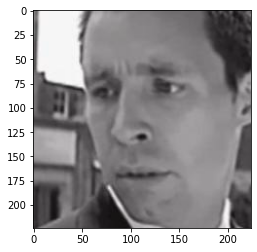

In [14]:
train_data_path = '/content/traindata/train_set/images/*'
test_data_path = '/content/testdata/val_set/images/*'
train_image_paths = []
test_image_paths=[]
for data_path in glob.glob(train_data_path):
       train_image_paths.append(data_path)
for data_path in glob.glob(test_data_path):
       test_image_paths.append(data_path)

random.shuffle(train_image_paths)
image = cv2.imread(test_image_paths[0])
plt.imshow(image)
#Split the data into 80 and 20
train_image_allPath = train_image_paths
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
print(len(train_image_paths))
print(len(valid_image_paths))
print(len(train_image_allPath))

In [37]:
train_dataset = ImageDataSet(train_image_paths,'/content/traindata/train_set/annotations/',transform=img_transforms['train'])
valid_dataset = ImageDataSet(valid_image_paths,'/content/traindata/train_set/annotations/',transform=img_transforms['valid'])
test_dataset = ImageDataSet(test_image_paths,'/content/testdata/val_set/annotations/',transform=img_transforms['test'])
nSamples=countall(train_dataset)
t=min(nSamples)
normedWeights = [t/x for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights = normedWeights.to(torch.device("cuda"))
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=4,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_dataset,batch_size=32,num_workers=4,shuffle=True),
     'test': torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=4)
}



In [ ]:
#creating Model and training Mdel
use_cuda = torch.cuda.is_available()
model_transfer = MultilabelClassifier(8,1,1)

if use_cuda:
    model_transfer = model_transfer.cuda()

# selecting loss function
criterion_transfer = nn.CrossEntropyLoss(normedWeights)
loss_fn = nn.L1Loss()
#using Adam classifier
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)
n_epochs= 4
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/model4.pt')
tplot(taccuracy,vaccuracy,"Validation Accurcay and Training Accuracy Graph")
tplot(trainingloss,validationloss,"Validation Accurcay and Training Accuracy Graph")


In [40]:
checkpoint = torch.load('/content/drive/MyDrive/model2.pt', map_location='cpu')
model_transfer.load_state_dict(checkpoint)
model_transfer = model_transfer.cuda()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0], device='cuda:0')
tensor(0, device='cuda:0')
tensor([6], device='cuda:0')
tensor(6, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2], device='cuda:0')
tensor(3, device='cuda:0')
tensor([2], device='cuda:0')
tensor(4, device='cuda:0')


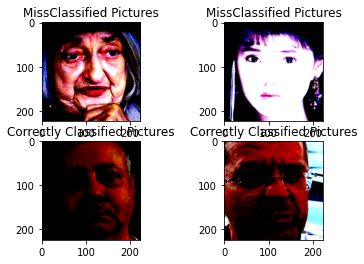

In [41]:
#testing of model
preds, targets, apreds, atargets, vpreds, vtargets = test(loaders_transfer, model_transfer,loss_fn, criterion_transfer, use_cuda)

In [42]:
#classification Report
calculate(preds,targets)

              precision    recall  f1-score   support

           0       0.47      0.58      0.52       500
           1       0.66      0.80      0.72       500
           2       0.62      0.60      0.61       500
           3       0.59      0.59      0.59       500
           4       0.70      0.58      0.63       500
           5       0.65      0.54      0.59       500
           6       0.56      0.62      0.59       500
           7       0.60      0.49      0.54       499

    accuracy                           0.60      3999
   macro avg       0.61      0.60      0.60      3999
weighted avg       0.61      0.60      0.60      3999



0.6009002250562641

In [44]:
print('Evaluation Measure for Valence')
vr=[vl,vcor,lvcon]=calculateRMSE(vpreds,vtargets)
print('Evaluation Measure for Arousal')
ar=[al,acor,acon]=calculateRMSE(apreds,atargets)


Evaluation Measure for Valence
RMSE: 0.430
SAGR: 0.730
Correlation: [1.         0.59543329]
concordance_correlation_coefficient: 0.549
Evaluation Measure for Arousal
RMSE: 0.363
SAGR: 0.782
Correlation: [1.         0.53465726]
concordance_correlation_coefficient: 0.458


In [49]:
calc(preds,targets)

Cohens Kappa Score: 0.544
Area Under Curve: 0.772
AUC – Precision Recall: 0.629
nominal metric: 0.544
F1-Score: 0.600
